In [1]:
from datasets import load_dataset
from transformers import (
    AutoTokenizer, 
    AutoModelForTokenClassification,
    TrainingArguments,
    Trainer,
    DataCollatorForTokenClassification,
    BertTokenizer
)
import numpy as np
import pandas as pd
import evaluate
import torch
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore')

In [2]:
dataset = load_dataset("ai4privacy/pii-masking-200k", split='train')

split_ds = dataset.train_test_split(test_size=0.2, seed=42, shuffle=True)
train_dataset = split_ds["train"]
temp_dataset = split_ds["test"]

val_test = temp_dataset.train_test_split(test_size=0.5, seed=42, shuffle=True)
val_dataset = val_test["train"]
test_dataset = val_test["test"]

print(f'Train: {len(train_dataset)}')
print(f'Val: {len(val_dataset)}')
print(f'Test: {len(test_dataset)}')

Train: 167408
Val: 20926
Test: 20927


In [3]:
all_labels = set()

def get_labels(item):
    global all_labels
    all_labels.update(set(item['mbert_bio_labels']))

dataset.map(get_labels, batched=False)

Map:   0%|          | 0/209261 [00:00<?, ? examples/s]

Dataset({
    features: ['source_text', 'target_text', 'privacy_mask', 'span_labels', 'mbert_text_tokens', 'mbert_bio_labels', 'id', 'language', 'set'],
    num_rows: 209261
})

In [4]:
id2label = {0: 'O'}
label2id = {'O': 0}

idx = 1
for label in all_labels:
    if label == 'O': continue
    id2label[idx] = label
    label2id[label] = idx

    idx += 1

In [5]:
def bio_labels2ner_tags(examples):
    global label2id

    converted_labels = list()

    for labels in examples["mbert_bio_labels"]:
        label_ids = [label2id[label] for label in labels]
        converted_labels.append(label_ids)

    return {'ner_tags': converted_labels}

train_dataset = train_dataset.map(bio_labels2ner_tags, batched=True)
val_dataset = val_dataset.map(bio_labels2ner_tags, batched=True)
test_dataset = test_dataset.map(bio_labels2ner_tags, batched=True)

Map:   0%|          | 0/167408 [00:00<?, ? examples/s]

Map:   0%|          | 0/20926 [00:00<?, ? examples/s]

Map:   0%|          | 0/20927 [00:00<?, ? examples/s]

In [6]:
model_name = "bert-base-multilingual-cased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [7]:
def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(
        examples["mbert_text_tokens"],
        truncation=True,
        is_split_into_words=True
    )

    labels = []
    for i, label in enumerate(examples["ner_tags"]):
        word_ids = tokenized_inputs.word_ids(batch_index=i)
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:
            if word_idx is None:
                label_ids.append(-100)
            elif word_idx != previous_word_idx:
                label_ids.append(label[word_idx])
            else:
                label_ids.append(-100)
            previous_word_idx = word_idx
        labels.append(label_ids)

    tokenized_inputs["labels"] = labels
    return tokenized_inputs

In [8]:
train_tok_ds = train_dataset.map(tokenize_and_align_labels, batched=True)
test_tok_ds = test_dataset.map(tokenize_and_align_labels, batched=True)
val_tok_ds = val_dataset.map(tokenize_and_align_labels, batched=True)

Map:   0%|          | 0/167408 [00:00<?, ? examples/s]

Map:   0%|          | 0/20927 [00:00<?, ? examples/s]

Map:   0%|          | 0/20926 [00:00<?, ? examples/s]

In [9]:
data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer)

In [10]:
seqeval = evaluate.load("seqeval")

In [11]:
def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    true_predictions = [
        [id2label[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]

    true_labels = [
        [id2label[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    results = seqeval.compute(predictions=true_predictions, references=true_labels)
    return {
        "precision": results["overall_precision"],
        "recall": results["overall_recall"],
        "f1": results["overall_f1"],
        "accuracy": results["overall_accuracy"],
    }

In [12]:
def init_model(model_name: str, freeze_weights: bool = True) -> torch.nn.Module:
    model = AutoModelForTokenClassification.from_pretrained(
        model_name,
        num_labels=len(id2label),
        id2label=id2label,
        label2id=label2id
    )

    print(model)

    if freeze_weights:
        for param in model.bert.parameters():
            param.requires_grad = False

    return model

In [13]:
def train_model(
    model: torch.nn.Module,
    learning_rate: float = 1e-5,
    batch_size: int = 16,
    weight_decay: float = 0.01,
    epochs: int = 12,
    lr_scheduler_type: str = 'linear'
) -> Trainer:
    training_args = TrainingArguments(
        output_dir="ner_model_head",
        learning_rate=learning_rate,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size // 2,
        num_train_epochs=epochs,
        weight_decay=weight_decay,
        lr_scheduler_type=lr_scheduler_type,
        eval_strategy="epoch",
        save_strategy="epoch",
        logging_dir="./logs",
        logging_steps=100,  
        load_best_model_at_end=True,
        gradient_accumulation_steps=4,
        report_to="none",
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_tok_ds,
        eval_dataset=val_tok_ds,
        data_collator=data_collator,
        compute_metrics=compute_metrics,
    )

    trainer.train()

    return trainer

In [14]:
def evaluate_model(
    trainer: Trainer
) -> None:
    log_history_df = pd.DataFrame(trainer.state.log_history)
    print(log_history_df.head())

    train_losses = []
    eval_losses = []
    eval_f1 = []
    eval_recall = []
    steps = []
    
    for log_entry in trainer.state.log_history:
        if 'loss' in log_entry:
            train_losses.append(log_entry['loss'])
            steps.append(log_entry['step'])
    
        if 'eval_loss' in log_entry:
            eval_losses.append(log_entry['eval_loss'])
    
        if 'eval_f1' in log_entry:
            eval_f1.append(log_entry['eval_f1'])

        if 'eval_recall' in log_entry:
            eval_recall.append(log_entry['eval_recall'])

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), sharex=True)
    eval_steps = [
        log_entry['step'] for log_entry in trainer.state.log_history if 'eval_loss' in log_entry
    ]
    ax1.plot(
        steps[:len(train_losses)], train_losses, label='Training Loss', color='blue', linewidth=2
    )

    if eval_losses:
        ax1.plot(eval_steps, eval_losses, label='Validation Loss', color='red', linewidth=2)
    
    ax1.set_ylabel('Loss')
    ax1.set_title('Training and Validation Loss')
    ax1.legend()
    ax1.grid(True)
    
    if eval_f1:
        ax2.plot(eval_steps, eval_f1, label='Validation F1-score', color='green', linewidth=2)
    
    if eval_recall:
        ax2.plot(eval_steps, eval_recall, label='Validation Recall', color='red', linewidth=2)
    
    ax2.set_xlabel('Training Steps')
    ax2.set_ylabel('Metric Value')
    ax2.set_title('Validation Metric Scores')
    ax2.legend()
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()

    test_predictions = trainer.predict(test_tok_ds)
    label_ids = test_predictions.label_ids
    test_predictions = np.argmax(test_predictions.predictions, axis=2)
    
    true_predictions = [
        [id2label[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(test_predictions, label_ids)
    ]
    
    true_labels = [
        [id2label[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(test_predictions, label_ids)
    ]
    
    detailed_results = seqeval.compute(predictions=true_predictions, references=true_labels)
    
    print("\nDetailed Test Results:")
    print(f"Overall Precision: {detailed_results['overall_precision']:.4f}")
    print(f"Overall Recall: {detailed_results['overall_recall']:.4f}")
    print(f"Overall F1: {detailed_results['overall_f1']:.4f}")
    print(f"Overall Accuracy: {detailed_results['overall_accuracy']:.4f}")
    
    print("\nPer-class Metrics:")
    for label, metrics in detailed_results.items():
        if label not in ['overall_precision', 'overall_recall', 'overall_f1', 'overall_accuracy']:
            print(f"{label}:")
            print(f"  Precision: {metrics['precision']:.4f}")
            print(f"  Recall: {metrics['recall']:.4f}")
            print(f"  F1: {metrics['f1']:.4f}")
            print(f"  Number: {metrics['number']}")

In [15]:
import gc

def empty_gpu_cache():
    torch.cuda.empty_cache()
    gc.collect()

**Fine-tuning (classifier only), 15 epochs, linear LR scheduler, weight_decay = 0.01, init_lr = 1e-5**

In [17]:
empty_gpu_cache()
model = init_model(model_name)
trainer = train_model(model, epochs=15)

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForTokenClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-1

Detected kernel version 3.10.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,2.300600,2.128540,0.001631,0.000186,0.000333,0.662666
2,1.490000,1.356562,0.000573,0.000278,0.000375,0.696519
3,1.201500,1.070780,0.006319,0.004917,0.005531,0.757308
4,1.041600,0.918409,0.031616,0.028576,0.030019,0.782440
5,0.942800,0.824697,0.064669,0.066044,0.065349,0.797936
6,0.872500,0.761069,0.093102,0.104130,0.098308,0.809158
7,0.827500,0.716474,0.113308,0.136387,0.123781,0.817678
8,0.795100,0.683591,0.127878,0.161824,0.142862,0.824124
9,0.767200,0.658900,0.138143,0.182499,0.157253,0.829115
10,0.750900,0.640386,0.147494,0.199926,0.169753,0.833264


     loss  grad_norm  learning_rate     epoch  step  eval_loss  \
0  4.5261  22.320969        0.00001  0.076453   100        NaN   
1  4.2587  21.854538        0.00001  0.152905   200        NaN   
2  4.0056  20.580786        0.00001  0.229358   300        NaN   
3  3.7704  20.427065        0.00001  0.305810   400        NaN   
4  3.5530  19.461901        0.00001  0.382263   500        NaN   

   eval_precision  eval_recall  eval_f1  eval_accuracy  eval_runtime  \
0             NaN          NaN      NaN            NaN           NaN   
1             NaN          NaN      NaN            NaN           NaN   
2             NaN          NaN      NaN            NaN           NaN   
3             NaN          NaN      NaN            NaN           NaN   
4             NaN          NaN      NaN            NaN           NaN   

   eval_samples_per_second  eval_steps_per_second  train_runtime  \
0                      NaN                    NaN            NaN   
1                      NaN        

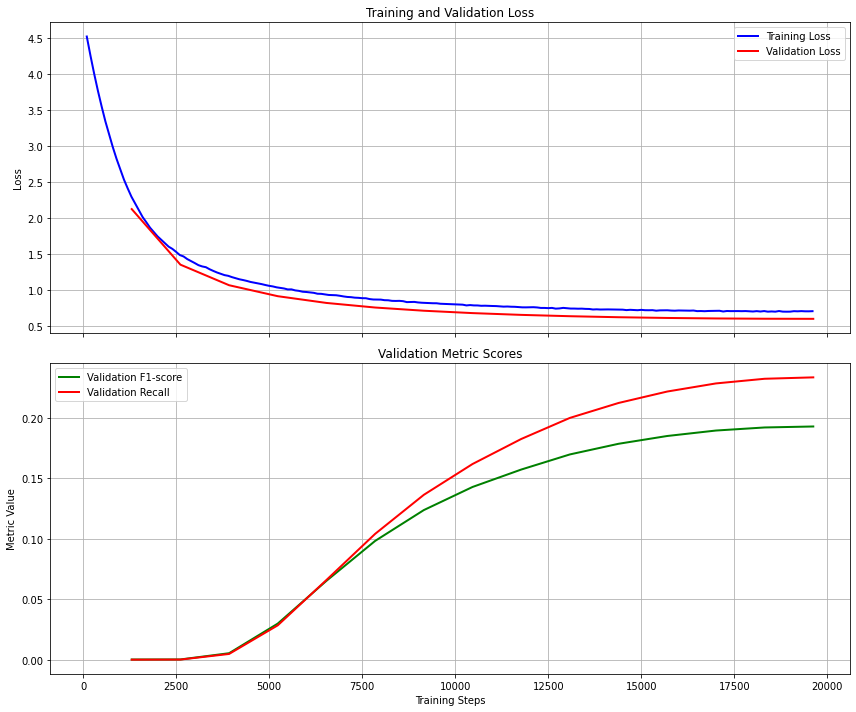


Detailed Test Results:
Overall Precision: 0.1590
Overall Recall: 0.2285
Overall F1: 0.1875
Overall Accuracy: 0.8392

Per-class Metrics:
ACCOUNTNAME:
  Precision: 0.6073
  Recall: 0.6594
  F1: 0.6323
  Number: 1189
ACCOUNTNUMBER:
  Precision: 0.0097
  Recall: 0.0171
  F1: 0.0124
  Number: 1226
AGE:
  Precision: 0.5645
  Recall: 0.5118
  F1: 0.5368
  Number: 1317
AMOUNT:
  Precision: 0.0408
  Recall: 0.0304
  F1: 0.0348
  Number: 1250
BIC:
  Precision: 0.0000
  Recall: 0.0000
  F1: 0.0000
  Number: 348
BITCOINADDRESS:
  Precision: 0.0639
  Recall: 0.3922
  F1: 0.1099
  Number: 1127
BUILDINGNUMBER:
  Precision: 0.3211
  Recall: 0.3065
  F1: 0.3136
  Number: 1315
CITY:
  Precision: 0.0079
  Recall: 0.0024
  F1: 0.0037
  Number: 1240
COMPANYNAME:
  Precision: 0.0354
  Recall: 0.0229
  F1: 0.0278
  Number: 1224
COUNTY:
  Precision: 0.5249
  Recall: 0.4151
  F1: 0.4636
  Number: 1272
CREDITCARDCVV:
  Precision: 0.0000
  Recall: 0.0000
  F1: 0.0000
  Number: 405
CREDITCARDISSUER:
  Precision:

In [18]:
evaluate_model(trainer)

**Fine-tuning (classifier only), 15 epochs, cosine LR scheduler, weight_decay = 0.01, init_lr = 1e-5**

In [ ]:
empty_gpu_cache()
model = init_model(model_name)
trainer = train_model(model, lr_scheduler_type="cosine")

In [ ]:
evaluate_model(trainer)